In [1]:
import math
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv
Saving Valid.csv to Valid.csv


In [3]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
valid_df = pd.read_csv("Valid.csv")

In [4]:
train_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
test_df.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [6]:
valid_df.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [7]:
print(train_df.shape,test_df.shape, valid_df.shape)

(40000, 2) (5000, 2) (5000, 2)


In [8]:
X_train, X_test, X_valid = train_df['text'], test_df['text'], valid_df['text']
Y_train, Y_test, Y_valid = train_df['label'], test_df['label'], valid_df['label']

## Perform required text pre-processing – lowering text, removing URLs, punctuation , stopwords and correct spelling

In [9]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)                                          
    text = re.sub(r'http\S+', '', text)                                           
    text = text.lower()                                                           
    text = [w for w in text.split(' ') if w not in stop_words]                     
    text = " ".join(text)
    return text

In [11]:
X_train = X_train.apply(lambda x: preprocess(x))
X_test = X_test.apply(lambda x: preprocess(x))
X_valid = X_valid.apply(lambda x: preprocess(x))

## Perform tokenization and lemmatization on cleaned data

In [12]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
X_train = X_train.apply(lambda x: WordNetLemmatizer().lemmatize(x))
X_Valid = X_valid.apply(lambda x: WordNetLemmatizer().lemmatize(x))
X_test = X_test.apply(lambda x: WordNetLemmatizer().lemmatize(x))

In [14]:
X_train.head()

0    grew b 1965 watching loving thunderbirds mates...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

In [15]:
X_test.head()

0    always wrote series complete stinkfest jim bel...
1    1st watched 1272002  3 10dirsteve purcell typi...
2    movie poorly written directed fell asleep 30 m...
3    interesting thing miryang secret sunshine acto...
4    first read berlin meer didnt expect much thoug...
Name: text, dtype: object

In [16]:
X_valid.head()

0    14 years since sharon stone awarded viewers le...
1    someone needed make car payment truly awful ma...
2    guidelines state comment must contain minimum ...
3    movie muddled mishmash clichés recent cinema p...
4    stan laurel became smaller half alltime greate...
Name: text, dtype: object

## train-test visualization

In [17]:
def visualise_train(history):
  sns.set_style("darkgrid")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)



  #Train and validation loss
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

## Visualize the most frequent words and bigrams

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

### visualization of most frequent words

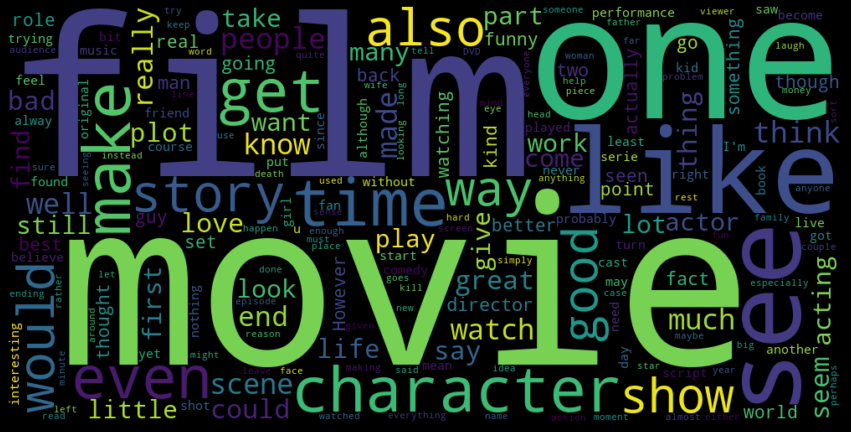

In [19]:
text = " ".join(i for i in train_df.text)
stop_words = ["br"] + list(stop_words)
wordcloud = WordCloud(stopwords=stop_words, width=1000, height=500).generate(text)
plt.figure(figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Bigrams of most frequent words

In [20]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

words = train_df['text'].tolist()

tokenized = [word_tokenize(i) for i in words]
flat_list = [num for sublist in tokenized for num in sublist]

bigram_df = pd.DataFrame(pd.Series(nltk.ngrams(flat_list, 2)).value_counts()).rename_axis('bigram').reset_index('bigram')
bigram_df.columns = ['bigram', 'count']
bigram_df['bigram'] = bigram_df['bigram'].astype("string")
bigram_df.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,bigram,count
0,"('<', 'br')",161462
1,"('br', '/')",161462
2,"('/', '>')",161462
3,"('>', '<')",80762
4,"('of', 'the')",60065
5,"(',', 'and')",46979
6,"('.', 'The')",42273
7,"('in', 'the')",36798
8,"('.', 'I')",35726
9,"(',', 'but')",33313


### Tokenization

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)


X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=120)
X_valid = pad_sequences(X_valid, maxlen=120)
X_test = pad_sequences(X_test, maxlen=120)

In [22]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

160302


## LSTM

In [29]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout
import tensorflow as tf

def LSTM_Model():
  model = tf.keras.Sequential([
      Embedding(size_of_vocabulary, 128, input_length = 120),
      LSTM(15, return_sequences=True),
      Dropout(0.05),
      Dense(1, activation='sigmoid')
  ])
  model.summary()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [31]:
lstmModel = LSTM_Model()
lstmHistory = lstmModel.fit(X_train, Y_train, batch_size = 128, epochs = 4,validation_data = (X_valid, Y_valid), verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 128)          20518656  
                                                                 
 lstm_1 (LSTM)               (None, 120, 15)           8640      
                                                                 
 dropout_1 (Dropout)         (None, 120, 15)           0         
                                                                 
 dense_1 (Dense)             (None, 120, 1)            16        
                                                                 
Total params: 20,527,312
Trainable params: 20,527,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
313/313 [==============================] - 10s 26ms/step - loss: 0.5397 - accuracy: 0.6976 - val_loss: 0.5007 - val_accuracy: 0.7214
Epoch 2/4
313/313 [============

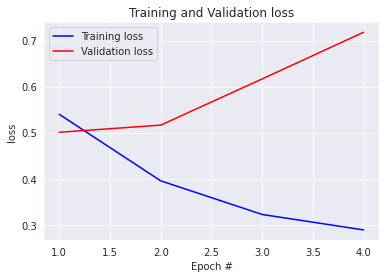

In [32]:
visualise_train(lstmHistory)

In [33]:
lstmTest = lstmModel.evaluate(X_test, Y_test)

157/157 [==============================] - 1s 7ms/step - loss: 0.7104 - accuracy: 0.7114


## BidRNN

In [34]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout, Bidirectional

def RNN_Model():
  model = tf.keras.Sequential([
      Embedding(size_of_vocabulary,128,input_length=120),
      Bidirectional(SimpleRNN(20, return_sequences= True,dropout=0.2)),
      Dense(1, activation='sigmoid')
  ])

  model.summary()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [35]:
rnnModel = RNN_Model()
rnnHistory = rnnModel.fit(X_train, Y_train, batch_size = 128, epochs = 4, validation_data = (X_valid, Y_valid), verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 128)          20518656  
                                                                 
 bidirectional (Bidirectiona  (None, 120, 40)          5960      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 120, 1)            41        
                                                                 
Total params: 20,524,657
Trainable params: 20,524,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
313/313 [==============================] - 100s 315ms/step - loss: 0.4530 - accuracy: 0.7935 - val_loss: 0.3725 - val_accuracy: 0.8517
Epoch 2/4
313/313 [==============================] - 91s 290ms/step - loss: 0.2183 - accuracy: 

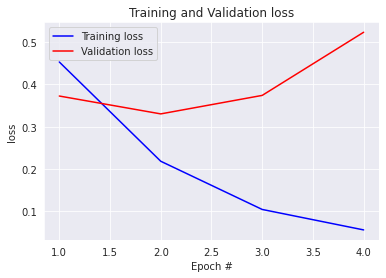

In [36]:
visualise_train(rnnHistory)

In [38]:
rnnTest = rnnModel.evaluate(X_test, Y_test)

157/157 [==============================] - 6s 37ms/step - loss: 0.4794 - accuracy: 0.8725


## Build your own test dataset with 10 movie reviews and tabulate accuracy

In [42]:
from google.colab import files
uploaded = files.upload()

Saving myData.csv to myData.csv


In [43]:
myData = pd.read_csv("myData.csv")

In [48]:
myData.head(10)

,text,label
0,"A jewel in Disney's animated crown, Aladdin is...",0
1,The second chapter of IT is not even half as s...,0
2,I get why some people hate this . It's because...,0
3,Best Netflix original ever made. The entire ca...,0
4,I had zero expectations and it turned out to b...,0
5,I have to say that I had seen the previews for...,1
6,Wyatt Earp cleans up the title town after it's...,1
7,"In Arizona, wisecracking carnival showman Will...",0
8,"William DeMille, brother of Cecil, directed on...",1
9,Did the title get you here? Good. This is impo...,0


In [44]:
X_myData = myData['text']
Y_myData = myData['label']

X_myData = X_myData.apply(lambda x: preprocess(x))
X_myData = X_myData.apply(lambda x: WordNetLemmatizer().lemmatize(x))

X_myData = tokenizer.texts_to_sequences(X_myData)
X_myData = pad_sequences(X_myData, maxlen=120)

In [46]:
lstmModel.evaluate(X_myData, Y_myData)

1/1 [==============================] - 0s 25ms/step - loss: 0.6198 - accuracy: 0.4767


[0.6197925806045532, 0.4766666293144226]

In [49]:
rnnModel.evaluate(X_myData, Y_myData)

1/1 [==============================] - 0s 45ms/step - loss: 1.7344 - accuracy: 0.6058


[1.7344436645507812, 0.6058333516120911]